Small sonnet dataset

In [1]:
import requests

# URL of the file
url = "https://www.ccs.neu.edu/home/vip/teach/DMcourse/data/sonnetsPreprocessed.txt"

# Download the file
response = requests.get(url)
if response.status_code == 200:
    with open("sonnetsPreprocessed.txt", "w", encoding="utf-8") as file:
        file.write(response.text)
    print("File downloaded successfully.")
else:
    print("Failed to download the file.")

File downloaded successfully.


In [ ]:
with open("sonnetsPreprocessed.txt", "r", encoding="utf-8") as file:
    text_data = file.readlines()
print(text_data[0:5])  

['fairest creatures desire increase thereby beautys rose might never die riper time decease tender heir might bear memory thou contracted thine own bright eyes feedst thy lights flame selfsubstantial fuel making famine abundance lies thy self thy foe thy sweet self cruel thou art worlds fresh ornament herald gaudy spring thine own bud buriest thy content tender churl makst waste niggarding pity world else glutton eat worlds due grave thee\n', 'forty winters shall besiege thy brow dig deep trenches thy beautys field thy youths proud livery gazed tatterd weed small worth held asked thy beauty lies treasure thy lusty days say thine own deep sunken eyes alleating shame thriftless praise praise deservd thy beautys thou couldst answer fair child mine shall sum count make old excuse proving beauty succession thine new made thou art old thy blood warm thou feelst cold\n', 'look thy glass tell face thou viewest time face form another whose fresh repair thou renewest thou dost beguile world unbl

In [10]:
len(text_data)

154

In [18]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Define stopwords
stop_words = set(stopwords.words('english'))

def preprocess(texts, min_freq = 5, max_freq_ratio = 0.5):
    stop_words = set(stopwords.words('english'))
    all_tokens = []
    
    for text in texts:
        tokens = re.findall(r'\b\w+\b', text.lower())
        tokens = [token for token in tokens if token not in stop_words]
        all_tokens.append(tokens)
        
    flat_tokens = [token for doc in all_tokens for token in doc]
    word_freq = Counter(flat_tokens)
    num_docs = len(texts)
    
    vocab = [word for word, freq in word_freq.items() if freq >= min_freq and freq <= num_docs * max_freq_ratio]
    vocab_dict = {word: i for i, word in enumerate(vocab)}
    
    DOCS = []
    
    for tokens in all_tokens: 
        doc = [vocab_dict[word] for word in tokens if word in vocab_dict]
        DOCS.append(doc)
        
    return DOCS, vocab_dict
    

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hunjunsin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
DOCS, vocab_dict = preprocess(text_data, min_freq=5, max_freq_ratio=0.5)
print("Number of documents:", len(DOCS))
print("Number of unique words in vocabulary:", len(vocab_dict))
print("First documents:", DOCS[0])

Number of documents: 154
Number of unique words in vocabulary: 381
First documents: [0, 1, 2, 3, 4, 5, 6, 7, 8, 4, 9, 10, 11, 12, 13, 14, 15, 16, 17, 16, 18, 19, 20, 21, 22, 23, 11, 8, 24, 25, 26, 27, 20, 28]


In [ ]:
import numpy as np

K = 6
T = 1000

N = len(DOCS)
W = len(vocab_dict)

#prior parameters of the Dirichlet distribution
alpha_val = 0.5
beta_val = 2.0
alpha = np.full(K, alpha_val) # (K, )
beta = np.full(W, beta_val) # (W, )  

# document topic distribution
A = np.tile(alpha, (N, 1)) # (N, K)

# topic word distribution
B = np.tile(beta, (K, 1)) # (K, W) 
BSUM = np.sum(B, axis=1)  # (K, ) number of word in each topic

Z = []

# first randomly assign topics to words
for d, doc in enumerate(DOCS):
    current_doc_topics = []
    for w in doc:

        topic = np.random.randint(K)
        current_doc_topics.append(topic)

        # update the counts
        A[d, topic] += 1
        B[topic, w] += 1
        BSUM[topic] += 1
    Z.append(current_doc_topics)

# Gibbs sampling
# for T iterations
# for each document
# for each word in the document
# sample a new topic for the word
# and update the counts

for iteration in range(T):
    for d, doc in enumerate(DOCS):
        for i, w in enumerate(doc):
            current_topic = Z[d][i]

            if current_topic is not None:
                A[d, current_topic] -= 1
                B[current_topic, w] -= 1
                BSUM[current_topic] -= 1
            
            # p(topic = k| rest) ->  (A[d,k]) * (B[k,w] / BSUM[k])
            prob = A[d, :] * (B[:, w] / BSUM)
            prob /= np.sum(prob)
            
            new_topic = np.random.choice(K, p = prob)
            Z[d][i] = new_topic
            
            A[d, new_topic] += 1
            B[new_topic, w] += 1
            BSUM[new_topic] += 1
    
    if (iteration +1) % 100 == 0:
        print(f"Iteration {iteration + 1} completed.")

theta = A / A.sum(axis = 1, keepdims=True)
phi = B / B.sum(axis =1, keepdims=True)
print("Theta shape:", theta.shape)
print("Phi shape:", phi.shape)


print("topic per documents:")
print(theta[:5])
print("word per topic:")
print(phi[0, :])

Iteration 100 completed.
Iteration 200 completed.
Iteration 300 completed.
Iteration 400 completed.
Iteration 500 completed.
Iteration 600 completed.
Iteration 700 completed.
Iteration 800 completed.
Iteration 900 completed.
Iteration 1000 completed.
Theta shape: (154, 6)
Phi shape: (6, 381)
topic per documents:
[[0.06756757 0.87837838 0.01351351 0.01351351 0.01351351 0.01351351]
 [0.01351351 0.7972973  0.01351351 0.12162162 0.04054054 0.01351351]
 [0.01515152 0.89393939 0.04545455 0.01515152 0.01515152 0.01515152]
 [0.04545455 0.74242424 0.04545455 0.04545455 0.04545455 0.07575758]
 [0.08333333 0.05       0.01666667 0.45       0.38333333 0.01666667]]
word per topic:
[0.00224719 0.00524345 0.00149813 0.00149813 0.00524345 0.00299625
 0.00224719 0.00374532 0.00224719 0.00224719 0.00224719 0.00524345
 0.00449438 0.00149813 0.00224719 0.00149813 0.00149813 0.00299625
 0.00224719 0.00524345 0.00149813 0.00224719 0.00224719 0.00149813
 0.00299625 0.00224719 0.00149813 0.00299625 0.00149813 

In [47]:
vocab_dict.items()

dict_items([('fairest', 0), ('desire', 1), ('beautys', 2), ('rose', 3), ('might', 4), ('never', 5), ('die', 6), ('time', 7), ('tender', 8), ('bear', 9), ('memory', 10), ('thine', 11), ('bright', 12), ('eyes', 13), ('making', 14), ('lies', 15), ('self', 16), ('sweet', 17), ('cruel', 18), ('art', 19), ('worlds', 20), ('fresh', 21), ('ornament', 22), ('spring', 23), ('waste', 24), ('pity', 25), ('world', 26), ('else', 27), ('due', 28), ('winters', 29), ('shall', 30), ('brow', 31), ('deep', 32), ('proud', 33), ('worth', 34), ('beauty', 35), ('treasure', 36), ('days', 37), ('say', 38), ('shame', 39), ('praise', 40), ('fair', 41), ('child', 42), ('mine', 43), ('make', 44), ('old', 45), ('excuse', 46), ('new', 47), ('made', 48), ('blood', 49), ('cold', 50), ('look', 51), ('glass', 52), ('tell', 53), ('face', 54), ('form', 55), ('another', 56), ('whose', 57), ('dost', 58), ('tomb', 59), ('calls', 60), ('back', 61), ('lovely', 62), ('age', 63), ('shalt', 64), ('despite', 65), ('wrinkles', 66), 

In [51]:
idx_to_word = {idx: word for word, idx in vocab_dict.items()}

In [52]:
idx_to_word.items()

dict_items([(0, 'fairest'), (1, 'desire'), (2, 'beautys'), (3, 'rose'), (4, 'might'), (5, 'never'), (6, 'die'), (7, 'time'), (8, 'tender'), (9, 'bear'), (10, 'memory'), (11, 'thine'), (12, 'bright'), (13, 'eyes'), (14, 'making'), (15, 'lies'), (16, 'self'), (17, 'sweet'), (18, 'cruel'), (19, 'art'), (20, 'worlds'), (21, 'fresh'), (22, 'ornament'), (23, 'spring'), (24, 'waste'), (25, 'pity'), (26, 'world'), (27, 'else'), (28, 'due'), (29, 'winters'), (30, 'shall'), (31, 'brow'), (32, 'deep'), (33, 'proud'), (34, 'worth'), (35, 'beauty'), (36, 'treasure'), (37, 'days'), (38, 'say'), (39, 'shame'), (40, 'praise'), (41, 'fair'), (42, 'child'), (43, 'mine'), (44, 'make'), (45, 'old'), (46, 'excuse'), (47, 'new'), (48, 'made'), (49, 'blood'), (50, 'cold'), (51, 'look'), (52, 'glass'), (53, 'tell'), (54, 'face'), (55, 'form'), (56, 'another'), (57, 'whose'), (58, 'dost'), (59, 'tomb'), (60, 'calls'), (61, 'back'), (62, 'lovely'), (63, 'age'), (64, 'shalt'), (65, 'despite'), (66, 'wrinkles'), 

Topic: 0


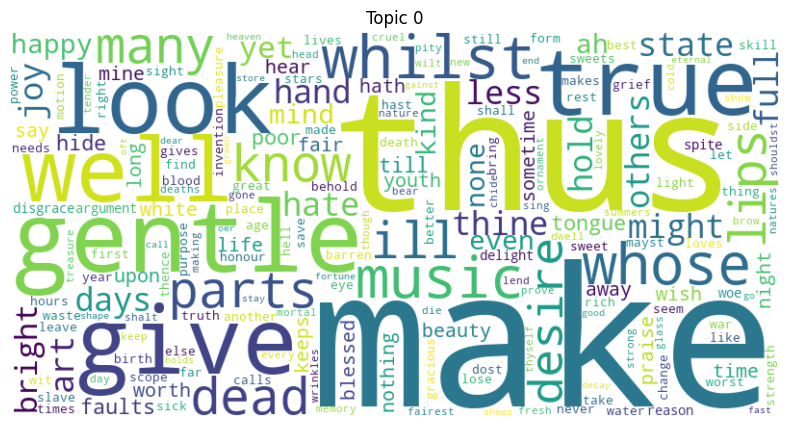

Topic: 1


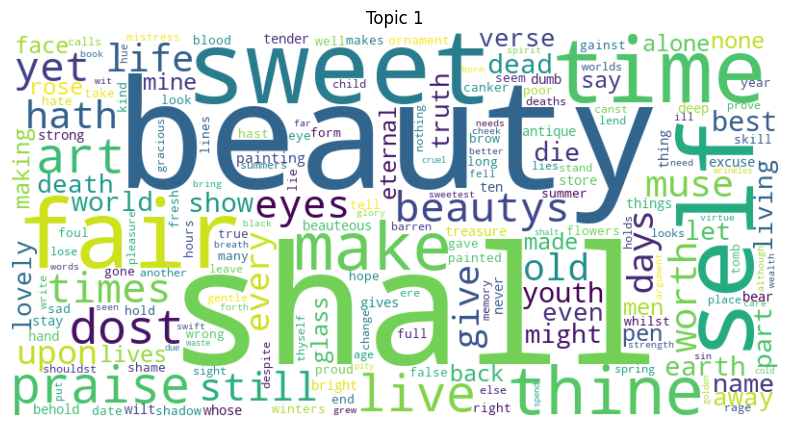

Topic: 2


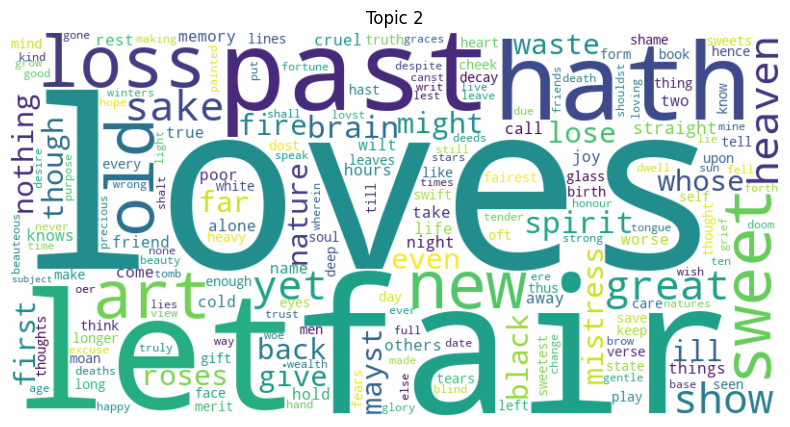

Topic: 3


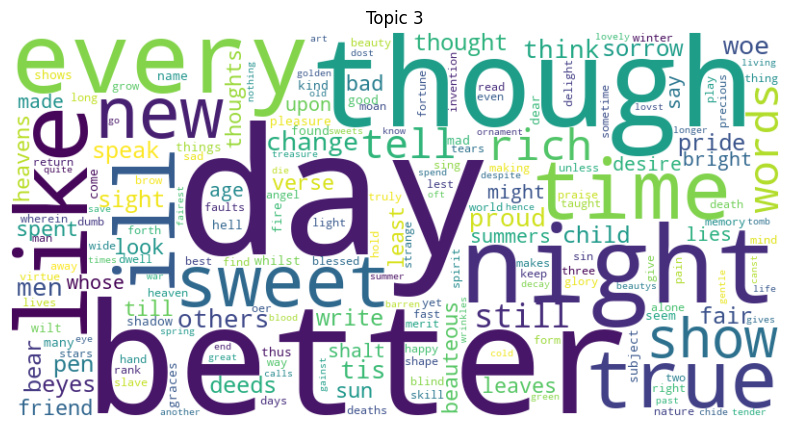

Topic: 4


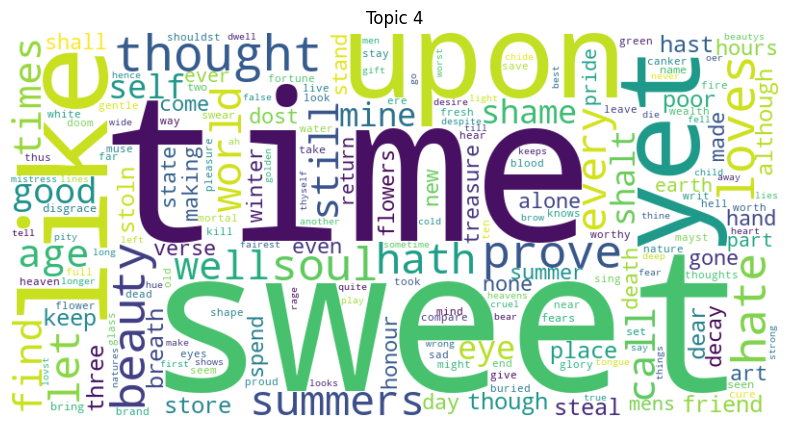

Topic: 5


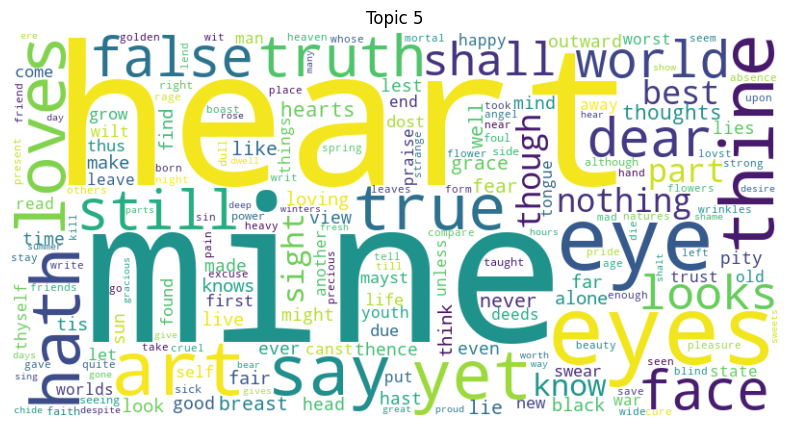

In [55]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

K = phi.shape[0]

for k in range(K):
    print(f"Topic: {k}")
    topic_dist = phi[k]
    
    # {word: probability}
    word_weights = {idx_to_word[i]: topic_dist[i] for i in range(len(topic_dist))}
    
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_weights)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {k}")
    plt.show()

In [85]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_csv = "/Users/hunjunsin/Desktop/Jun/Unsupervised/hw1/20news_train.csv"

train_data = pd.read_csv(train_csv)

train_data = train_data.sample(n = 1000, random_state = 42)

print(f"data number : {len(train_data)}")


data number : 1000


In [86]:
train_data.shape

(1000, 7)

In [87]:
text_20=train_data['body']

In [88]:
len(text_20)

1000

In [95]:
def preprocess(texts, min_freq=10, max_freq_ratio=0.5):
    stop_words = set(stopwords.words('english'))
    all_tokens = []
    
    for text in texts:
        if not isinstance(text, str):  # Ensure the text is a string
            text = ""
        text = re.sub(r'\b\d+\.\d+\b', '', text)  # Remove floating-point numbers
        text = re.sub(r'\b\d+\b', '', text)  # Remove integers
        tokens = re.findall(r'\b\w+\b', text.lower())
        tokens = [token for token in tokens if token not in stop_words]
        all_tokens.append(tokens)
        
    flat_tokens = [token for doc in all_tokens for token in doc]
    word_freq = Counter(flat_tokens)
    num_docs = len(texts)
    
    vocab = [word for word, freq in word_freq.items() if freq >= min_freq and freq <= num_docs * max_freq_ratio]
    vocab_dict = {word: i for i, word in enumerate(vocab)}
    
    DOCS = []
    
    for tokens in all_tokens: 
        doc = [vocab_dict[word] for word in tokens if word in vocab_dict]
        DOCS.append(doc)
        
    return DOCS, vocab_dict


In [96]:
DOCS_20, vocab_dict_20 = preprocess(text_20, min_freq=5, max_freq_ratio=0.5)

In [97]:
len(vocab_dict_20)

5741

In [98]:
import numpy as np

K = 6
T = 1000

N = len(DOCS_20)
W = len(vocab_dict_20)

#prior parameters of the Dirichlet distribution
alpha_val = 0.5
beta_val = 2.0
alpha = np.full(K, alpha_val) # (K, )
beta = np.full(W, beta_val) # (W, )  

# document topic distribution
A = np.tile(alpha, (N, 1)) # (N, K)

# topic word distribution
B = np.tile(beta, (K, 1)) # (K, W) 
BSUM = np.sum(B, axis=1)  # (K, ) number of word in each topic

Z = []

# first randomly assign topics to words
for d, doc in enumerate(DOCS_20):
    current_doc_topics = []
    for w in doc:

        topic = np.random.randint(K)
        current_doc_topics.append(topic)

        # update the counts
        A[d, topic] += 1
        B[topic, w] += 1
        BSUM[topic] += 1
    Z.append(current_doc_topics)

# Gibbs sampling
# for T iterations
# for each document
# for each word in the document
# sample a new topic for the word
# and update the counts

for iteration in range(T):
    for d, doc in enumerate(DOCS_20):
        for i, w in enumerate(doc):
            current_topic = Z[d][i]

            if current_topic is not None:
                A[d, current_topic] -= 1
                B[current_topic, w] -= 1
                BSUM[current_topic] -= 1
            
            # p(topic = k| rest) ->  (A[d,k]) * (B[k,w] / BSUM[k])
            prob = A[d, :] * (B[:, w] / BSUM)
            prob /= np.sum(prob)
            
            new_topic = np.random.choice(K, p = prob)
            Z[d][i] = new_topic
            
            A[d, new_topic] += 1
            B[new_topic, w] += 1
            BSUM[new_topic] += 1
    
    if (iteration +1) % 100 == 0:
        print(f"Iteration {iteration + 1} completed.")

theta = A / A.sum(axis = 1, keepdims=True)
phi = B / B.sum(axis =1, keepdims=True)
print("Theta shape:", theta.shape)
print("Phi shape:", phi.shape)


print("topic per documents:")
print(theta[:5])
print("word per topic:")
print(phi[0, :])

Iteration 100 completed.
Iteration 200 completed.
Iteration 300 completed.
Iteration 400 completed.
Iteration 500 completed.
Iteration 600 completed.
Iteration 700 completed.
Iteration 800 completed.
Iteration 900 completed.
Iteration 1000 completed.
Theta shape: (1000, 6)
Phi shape: (6, 5741)
topic per documents:
[[1.22222222e-01 1.11111111e-02 1.88888889e-01 1.11111111e-02
  3.33333333e-02 6.33333333e-01]
 [5.05050505e-03 2.77777778e-01 3.53535354e-02 6.51515152e-01
  2.52525253e-02 5.05050505e-03]
 [5.15463918e-03 2.62886598e-01 4.27835052e-01 2.52577320e-01
  1.54639175e-02 3.60824742e-02]
 [1.46406389e-02 4.43655723e-04 2.21827862e-03 4.43655723e-04
  8.38952972e-01 1.43300799e-01]
 [7.92682927e-02 2.86585366e-01 6.09756098e-03 6.15853659e-01
  6.09756098e-03 6.09756098e-03]]
word per topic:
[5.01803356e-04 1.56813549e-04 6.27254195e-05 ... 2.82264388e-04
 2.50901678e-04 6.27254195e-05]


In [99]:
idx_to_word_20 = {idx: word for word, idx in vocab_dict_20.items()}

Topic: 0


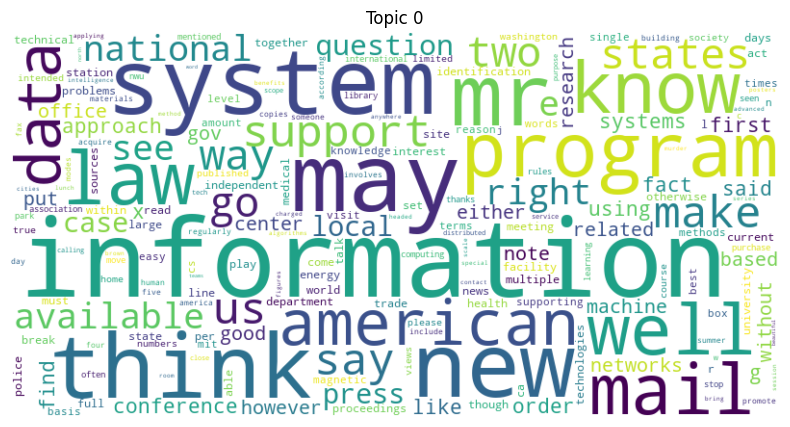

Topic: 1


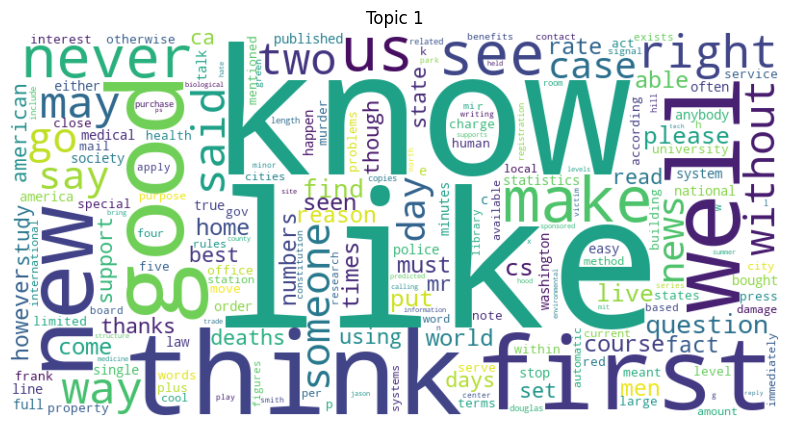

Topic: 2


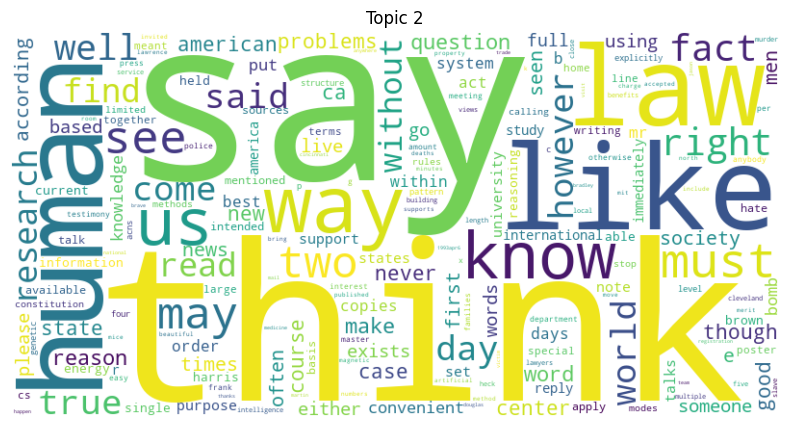

Topic: 3


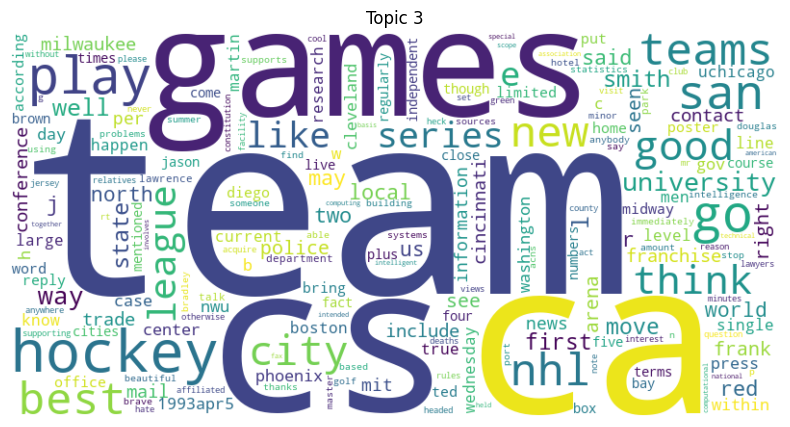

Topic: 4


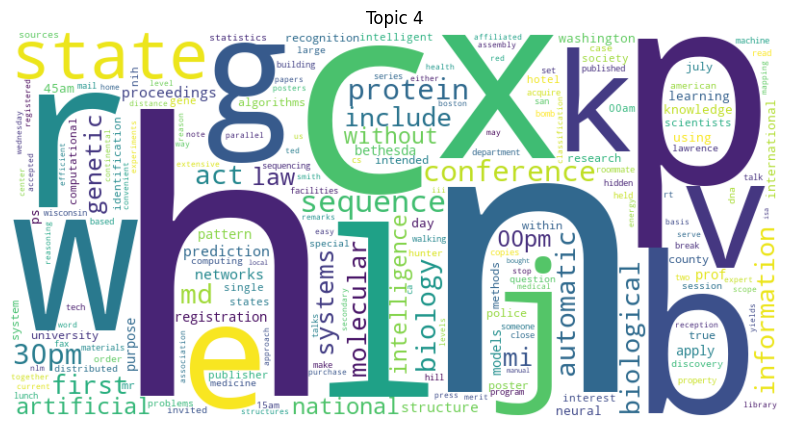

Topic: 5


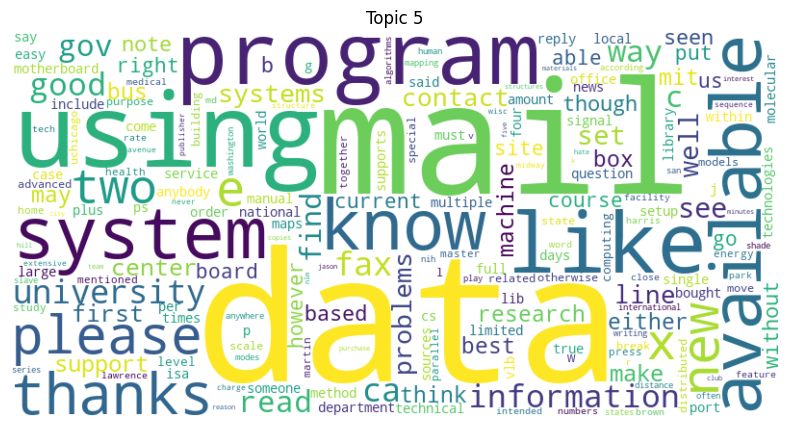

In [100]:
K = phi.shape[0]

for k in range(K):
    print(f"Topic: {k}")
    topic_dist_20 = phi[k]
    
    # {word: probability}
    word_weights = {idx_to_word_20[i]: topic_dist_20[i] for i in range(len(topic_dist))}
    
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_weights)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {k}")
    plt.show()